In [1]:
import sys
sys.path.append("../")
from limit_threads import *

NUMBER OF THREADS IS LIMITED NOW ...


In [79]:
import glob
import os
import random
import numpy as np
from compute_embedding import SpeechEmbedding
from speaker_encoder.io import load_config
import umap
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import pickle

## Load model

In [3]:
model_path = "../pretrained_model/best_model.pth.tar"
config_path = "../pretrained_model/config.json"
config = load_config(config_path)

speech_embedding = SpeechEmbedding(config, model_path)

 > Setting up Audio Processor...
 | > sample_rate:16000
 | > num_mels:80
 | > min_level_db:-100
 | > frame_shift_ms:None
 | > frame_length_ms:None
 | > ref_level_db:20
 | > fft_size:1024
 | > power:1.5
 | > preemphasis:0.98
 | > griffin_lim_iters:60
 | > signal_norm:True
 | > symmetric_norm:True
 | > mel_fmin:0
 | > mel_fmax:8000.0
 | > spec_gain:20.0
 | > stft_pad_mode:reflect
 | > max_norm:4.0
 | > clip_norm:True
 | > do_trim_silence:True
 | > trim_db:60
 | > do_sound_norm:False
 | > stats_path:None
 | > hop_length:256
 | > win_length:1024


## Read list of wav files and randomly select 10 wav files per speaker

In [64]:
comvoice_path = "/netscratch/hhemati/Datasets/Speech/OriginalData/comvoi/de/"

all_speaker_folders = glob.glob(os.path.join(comvoice_path, "wavs/*"))

wav_files = []
for speaker_folder in all_speaker_folders:
    speaker_wav_files = glob.glob(os.path.join(speaker_folder, "*.wav"))
    random.shuffle(speaker_wav_files)
    wav_files.extend(speaker_wav_files[:10])

print(f"Number of wav files: {len(wav_files)}")


Number of wav files: 390


## Compute embedding vectors for the wav files

In [61]:
embedding_dict = {}
for itr, wav_file in enumerate(wav_files):
    name = "/".join(wav_file.split("/")[-2:])
    print(f"Computing embedding for wav file {itr}/{len(wav_files)}.")
    embedd = speech_embedding.compute_embedding(wav_file)
    embedding_dict[name] = embedd[0]


Computing embedding for wav file 0/390.
Computing embedding for wav file 1/390.
Computing embedding for wav file 2/390.
Computing embedding for wav file 3/390.
Computing embedding for wav file 4/390.
Computing embedding for wav file 5/390.
Computing embedding for wav file 6/390.
Computing embedding for wav file 7/390.
Computing embedding for wav file 8/390.
Computing embedding for wav file 9/390.
Computing embedding for wav file 10/390.
Computing embedding for wav file 11/390.
Computing embedding for wav file 12/390.
Computing embedding for wav file 13/390.
Computing embedding for wav file 14/390.
Computing embedding for wav file 15/390.
Computing embedding for wav file 16/390.
Computing embedding for wav file 17/390.
Computing embedding for wav file 18/390.
Computing embedding for wav file 19/390.
Computing embedding for wav file 20/390.
Computing embedding for wav file 21/390.
Computing embedding for wav file 22/390.
Computing embedding for wav file 23/390.
Computing embedding for wa

## Visualize t-SNE reduction of the embedding

In [62]:
points = list(embedding_dict.values())
points = [list(p) for p in points]
points = np.array(points).astype(np.float32, copy=False)
print(points.shape)
# mapper = umap.UMAP().fit(points)
reduced_emb = TSNE(n_components=2).fit_transform(points)

(390, 256)


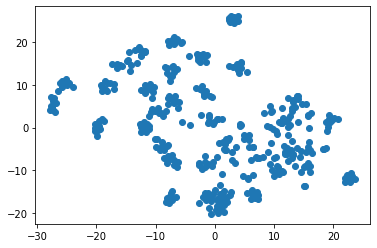

In [63]:
fig, ax = plt.subplots(1,1)
ax.scatter(reduced_emb[:,0], reduced_emb[:,1])

## Compute mean of embeddings per speaker

In [78]:
spk_embedding_means = {}
for key in embedding_dict.keys():
    speaker_name = key.split("/")[0]
    if not speaker_name in spk_embedding_means.keys():
        spk_embedding_means[speaker_name] = []
    
    spk_embedding_means[speaker_name].append(list(embedding_dict[key]))

for key in spk_embedding_means.keys():
    spk_embedding_means[key] = np.mean(np.array(spk_embedding_means[key]), axis=0)
print(spk_embedding_means.keys())

dict_keys(['09', '46', '31', '10', '22', '25', '52', '17', '36', '41', '04', '32', '45', '19', '13', '21', '51', '26', '14', '48', '07', '40', '37', '05', '24', '11', '29', '23', '02', '47', '49', '43', '06', '27', '50', '12', '01', '44', '33'])


## Save the mean embedding as pickle file

In [80]:
with open("comvoice.pkl", "wb") as pklfile:
    pickle.dump(spk_embedding_means, pklfile)